https://github.com/eschnett/SPH.jl/blob/master/src/SPH.jl

In [1]:
using Base

In [1]:
@enum test a b c

In [12]:
using LinearAlgebra
a = [3,4,0]
typeof(a)

Array{Int64,1}

## Simulation configuration datatype

In [2]:
struct simulationConfig
    endTime_::Float64
    deltaTime_::Float64
    
    particleRadius_::Float64
    influenceRadius_::Float64
    
    gravity_::Tuple{Float64,Float64,Float64}
    
    numWallLayer_::Int64
    numDummyLayer_::Int64
    
    simulationConfig(endTime::Float64, deltaTime::Float64, particleRadius::Float64) = new(endTime, deltaTime, particleRadius, 6.1*particleRadius, (0.0, -9.81, 0.0), 1, 3)
end

## Box domain datatype

In [3]:
struct boxDomain
    xMin_::Float64
    yMin_::Float64
    zMin_::Float64
    
    xMax_::Float64
    yMax_::Float64
    zMax_::Float64
    
    filledHeight_::Float64
end

## Particles datatype

In [4]:
mutable struct Particles
    size_::Int64
    posX_::Vector{Float64}
    posY_::Vector{Float64}
    posZ_::Vector{Float64}
    
    Particles() = new(0, Float64[],Float64[],Float64[])
end

function Base.resize!(p::Particles, size::Integer)
    p.size_ = size
    resize!(p.posX_, size)
    resize!(p.posY_, size)
    resize!(p.posZ_, size)
    
    return nothing
end

Particles(x::Int64) = (
                        p = Particles();
                        resize!(p,x);
                        return p;
                    )

methods(Particles)

# 2 methods for type constructor:
[1] Particles() in Main at In[4]:7
[2] Particles(x::Int64) in Main at In[4]:19

## Initialize Domain Function

In [21]:
using Printf

function initFluidParticles(config::simulationConfig, domain::boxDomain)
    
    if config.gravity_[1] == 0.0
        distX = domain.xMax_ - domain.xMin_
    else
        distX = domain.filledHeight_ - domain.xMin_
    end
        
    if config.gravity_[2] == 0.0
        distY = domain.yMax_ - domain.yMin_ 
    else
        distY = domain.filledHeight_ - domain.yMin_
    end
    
    if config.gravity_[3] == 0.0
        distZ = domain.zMax_ - domain.zMin_
    else
        distZ = domain.filledHeight_ - domain.zMin_
    end

    particleDiameter = 2*config.particleRadius_
    
    numParticleInX = Int64(round(distX / particleDiameter))
    numParticleInX = numParticleInX==0 ? 1 : numParticleInX
    
    numParticleInY = Int64(round(distY / particleDiameter))
    numParticleInY = numParticleInY==0 ? 1 : numParticleInY
    
    numParticleInZ = Int64(round(distZ / particleDiameter))
    numParticleInZ = numParticleInZ==0 ? 1 : numParticleInZ

    numParticles =numParticleInX *numParticleInY * numParticleInZ
    
    particles = Particles(numParticles)

    @inbounds for gk in 1 : numParticleInZ, gj in 1 : numParticleInY, gi in 1 : numParticleInX
                
        i = gi-1 + numParticleInX * (gj-1 + numParticleInY * (gk-1)) + 1   
        
        if numParticleInX == 1
            particles.posX_[i] = domain.xMin_
        else
            particles.posX_[i] = domain.xMin_ + config.particleRadius_ + (gi-1) * particleDiameter
        end

        if numParticleInY == 1
            particles.posY_[i] = domain.yMin_
        else
             particles.posY_[i] = domain.yMin_ + config.particleRadius_ + (gj-1) * particleDiameter
        end
          
        if numParticleInZ == 1
           particles.posZ_[i] = domain.zMin_
        else
            particles.posZ_[i] = domain.zMin_ + config.particleRadius_ + (gk-1) * particleDiameter
        end
        
        
    end
    
    return particles
end


function initWallParticles(config::simulationConfig, domain::boxDomain)
    
    distX = domain.xMax_ - domain.xMin_
    distY = domain.yMax_ - domain.yMin_ 
    distZ = domain.zMax_ - domain.zMin_

    particleDiameter = 2*config.particleRadius_
    
    numParticleInX = Int64(round(distX / particleDiameter))
    numParticleInX = numParticleInX==0 ? 1 : numParticleInX
    
    numParticleInY = Int64(round(distY / particleDiameter))
    numParticleInY = numParticleInY==0 ? 1 : numParticleInY
    
    numParticleInZ = Int64(round(distZ / particleDiameter))
    numParticleInZ = numParticleInZ==0 ? 1 : numParticleInZ

    numWallParticleInX = numParticleInX
    if numParticleInX != 1
        if config.gravity_[1] == 0.0
            numWallParticleInX = numParticleInX +2*config.numWallLayer_
        else
            numWallParticleInX = numParticleInX +config.numWallLayer_
        end
    end

    numWallParticleInY = numParticleInY
    if numParticleInY != 1
        if config.gravity_[2] == 0.0
            numWallParticleInY = numParticleInY +2*config.numWallLayer_
        else
            numWallParticleInY = numParticleInY +config.numWallLayer_
        end 
    end
    
    numWallParticleInZ = numParticleInZ
    if numParticleInZ != 1
        if config.gravity_[3] == 0.0
            numWallParticleInZ = numParticleInZ +2*config.numWallLayer_
        else
            numWallParticleInZ = numParticleInZ +config.numWallLayer_
        end 
    end
    
    numParticles =numWallParticleInX * numWallParticleInY * numWallParticleInZ - numParticleInX * numParticleInY * numParticleInZ
    
    particles = Particles(numParticles)

    counter = 1
    @inbounds for gk in 1 : numWallParticleInZ, gj in 1 : numWallParticleInY, gi in 1 : numWallParticleInX
                
        if numWallParticleInX == 1
            posX = domain.xMin_
        else
            if (config.gravity_[1] > 0)
                coeff =  gi    
            else
                coeff =  (gi-config.numWallLayer_)         
            end
            posX = domain.xMin_ - config.particleRadius_ + coeff * particleDiameter
        end

        if numWallParticleInY == 1
            posY = domain.yMin_
        else
            if (config.gravity_[2] > 0)
                coeff =  gj    
            else
                coeff =  (gj-config.numWallLayer_)         
            end
            posY = domain.yMin_ - config.particleRadius_ + coeff * particleDiameter
        end
          
        if numWallParticleInZ == 1
            posZ = domain.zMin_
        else
            if (config.gravity_[3] > 0)
                coeff =  gk    
            else
                coeff =  (gk-config.numWallLayer_)         
            end    
            posZ = domain.zMin_ - config.particleRadius_ + coeff * particleDiameter
        end
        
        if (domain.xMin_<=posX<=domain.xMax_ && domain.yMin_<=posY<=domain.yMax_ && domain.zMin_<=posZ<=domain.zMax_)
           continue 
        end

        particles.posX_[counter] = posX
        particles.posY_[counter] = posY
        particles.posZ_[counter] = posZ

        counter = counter +1
        
    end
    
    return particles
end

function initDummyParticles(config::simulationConfig, domain::boxDomain)
    
    distX = domain.xMax_ - domain.xMin_
    distY = domain.yMax_ - domain.yMin_ 
    distZ = domain.zMax_ - domain.zMin_

    particleDiameter = 2*config.particleRadius_
    
    numParticleInX = Int64(round(distX / particleDiameter))
    numParticleInX = numParticleInX==0 ? 1 : numParticleInX
    
    numParticleInY = Int64(round(distY / particleDiameter))
    numParticleInY = numParticleInY==0 ? 1 : numParticleInY
    
    numParticleInZ = Int64(round(distZ / particleDiameter))
    numParticleInZ = numParticleInZ==0 ? 1 : numParticleInZ

    numWallParticleInX = numParticleInX
    numDummyParticleInX = numParticleInX
    if numParticleInX != 1
        if config.gravity_[1] == 0.0
            numWallParticleInX = numParticleInX +2*config.numWallLayer_
            numDummyParticleInX = numWallParticleInX + 2*config.numDummyLayer_
        else
            numWallParticleInX = numParticleInX + config.numWallLayer_
            numDummyParticleInX = numWallParticleInX + config.numDummyLayer_
        end
    end

    numWallParticleInY = numParticleInY
    numDummyParticleInY = numParticleInY
    if numParticleInY != 1
        if config.gravity_[2] == 0.0
            numWallParticleInY = numParticleInY+2*config.numWallLayer_
            numDummyParticleInY = numWallParticleInY+ 2*config.numDummyLayer_
        else
            numWallParticleInY = numParticleInY + config.numWallLayer_
            numDummyParticleInY= numWallParticleInY+ config.numDummyLayer_
        end 
    end
    
    numWallParticleInZ = numParticleInZ
    numDummyParticleInZ = numParticleInZ
    if numParticleInZ != 1
        if config.gravity_[3] == 0.0
            numWallParticleInZ = numParticleInZ +2*config.numWallLayer_
            numDummyParticleInZ= numWallParticleInZ+ 2*config.numDummyLayer_
        else
            numWallParticleInZ = numParticleInZ + config.numWallLayer_
            numDummyParticleInZ= numWallParticleInZ + config.numDummyLayer_
        end 
    end
    
    numParticles =numDummyParticleInX * numDummyParticleInY * numDummyParticleInZ - numWallParticleInX * numWallParticleInY * numWallParticleInZ
    
    particles = Particles(numParticles)

    counter = 1
    @inbounds for gk in 1 : numDummyParticleInZ, gj in 1 : numDummyParticleInY, gi in 1 : numDummyParticleInX
                
        if numDummyParticleInX == 1
            posX = domain.xMin_
        else
            if (config.gravity_[1] > 0)
                coeff =  gi    
            else
                coeff =  (gi-(config.numDummyLayer_+config.numWallLayer_))         
            end
            posX = domain.xMin_ - config.particleRadius_ + coeff * particleDiameter
        end

        if numDummyParticleInY == 1
            posY = domain.yMin_
        else
            if (config.gravity_[2] > 0)
                coeff =  gj    
            else
                coeff =  (gj-(config.numDummyLayer_+config.numWallLayer_))         
            end
            posY = domain.yMin_ - config.particleRadius_ + coeff * particleDiameter
        end
          
        if numDummyParticleInZ == 1
            posZ = domain.zMin_
        else
            if (config.gravity_[3] > 0)
                coeff =  gk    
            else
                coeff =  (gk-(config.numDummyLayer_+config.numWallLayer_))         
            end    
            posZ = domain.zMin_ - config.particleRadius_ + coeff * particleDiameter
        end
        
#         @printf("%d %d %d\n", gi, gj, gk)
#         @printf("%d %f %f %f\n", counter, posX, posY, posZ)
        
        if (domain.xMin_ - config.numWallLayer_*particleDiameter <= posX<=domain.xMax_ + config.numWallLayer_*particleDiameter&&
            domain.yMin_ - config.numWallLayer_*particleDiameter <= posY<=domain.yMax_ + config.numWallLayer_*particleDiameter&&
            domain.zMin_ - config.numWallLayer_*particleDiameter <= posZ<=domain.zMax_ + config.numWallLayer_*particleDiameter)
           continue 
        end

        particles.posX_[counter] = posX
        particles.posY_[counter] = posY
        particles.posZ_[counter] = posZ

        counter = counter +1
        
    end
    
    return particles
end



initDummyParticles (generic function with 1 method)

In [27]:
config = simulationConfig(0.5, 0.01, 0.02)

simulationConfig(0.5, 0.01, 0.02, 0.122, (0.0, -9.81, 0.0), 1, 3)

In [28]:
domain = boxDomain(  0.0,  0.0,  0.0,
                    +1.0, +1.0, +0.0,
                     0.5)

boxDomain(0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.5)

In [29]:
fluidParticles = initFluidParticles(config, domain)

wallParticles = initWallParticles(config, domain)

dummyParticles = initDummyParticles(config, domain)
println(dummyParticles.size_)
size(dummyParticles.posZ_)
# size(dummyParticles.posZ_)

255


(255,)

In [30]:
using Plots

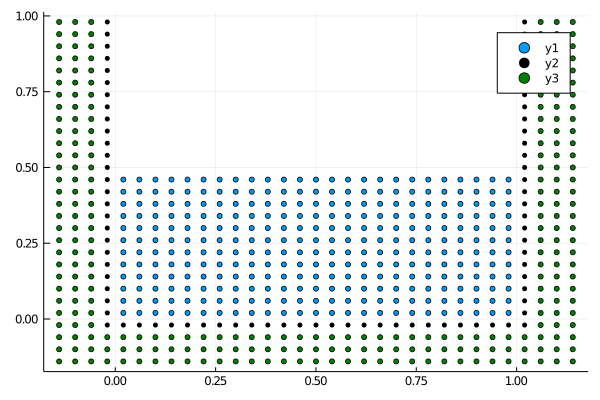

In [31]:
# function circleShape(c1::Float64, c2::Float64, r::Float64)
#     θ = collect(range(0.0, stop = 2*π, length = 50))
#     return c1.+r*sin.(θ), c2.+r*cos.(θ)
# end

plt3d = Plots.plot(fluidParticles.posX_, fluidParticles.posY_,
     seriestype=:scatter, markersize = 3)

# for i in 1 : fluidParticles.size_
#     Plots.plot!(circleShape(fluidParticles.posX_[i], fluidParticles.posY_[i], config.particleRadius_), seriestype=[:shape,], lw=0.5,c=:white,linecolor=:black,
#     legend =false, fillalpha = 0.2, aspect_ratio=1)
# end

Plots.plot!(wallParticles.posX_, wallParticles.posY_,
     seriestype=:scatter, markersize = 3 ,c=:black)

# for i in 1 : wallParticles.size_
#     Plots.plot!(circleShape(wallParticles.posX_[i], wallParticles.posY_[i], config.particleRadius_), seriestype=[:shape,], lw=0.5,c=:white,linecolor=:black,
#     legend =false, fillalpha = 0.2, aspect_ratio=1)
# end

Plots.plot!(dummyParticles.posX_, dummyParticles.posY_,
     seriestype=:scatter, markersize = 3 ,c=:green)

# for i in 1 : dummyParticles.size_
#     Plots.plot!(circleShape(dummyParticles.posX_[i], dummyParticles.posY_[i], config.particleRadius_), seriestype=[:shape,], lw=0.5,c=:white,linecolor=:black,
#     legend =false, fillalpha = 0.2, aspect_ratio=1)
# end

display(plt3d)